In [1]:
import pandas as pd
column_names = ['tag', 'text']
data = pd.read_fwf('TRAINING_DATA.txt', header=None, names=column_names)
from transformers import AutoTokenizer, AutoModel
import torch
# Load pre-trained Spanish BETO model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')
model = AutoModel.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

def embed_text(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Get the embedding for the [CLS] token
    embedding = outputs.last_hidden_state[0][0].numpy()
    return embedding

# Apply embedding to the 'sentences' column
data['embedding'] = data['text'].apply(embed_text)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/310 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/248k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/486k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
import string
# Function to calculate punctuation frequencies
def punctuation_frequency(text):
    punctuation_marks = string.punctuation
    punctuation_freq = {p: 0 for p in punctuation_marks}
    for char in text:
        if char in punctuation_marks:
            punctuation_freq[char] += 1
    return punctuation_freq
import re
import nltk

def preprocess_text(text):
    # Remove non-alphabetic characters and lowercase the text
    text = re.sub(r'[^a-zA-Z]', ' ', text).lower()
    # Tokenize the text
    tokens = text.split()
    # Remove stopwords (if needed) and return the preprocessed text
    return ' '.join(tokens)

  # Apply preprocessing
data['clean_text'] = data['text'].apply(preprocess_text)

# Perform POS tagging
data['pos_tags'] = data['clean_text'].apply(lambda x: ' '.join([pos for word, pos in nltk.pos_tag(nltk.word_tokenize(x))]))
# Add punctuation frequency features to the DataFrame
data['punctuation_freq'] = data['text'].apply(punctuation_frequency)

In [7]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [9]:
from sklearn.model_selection import train_test_split

X = data[['embedding', 'pos_tags', 'punctuation_freq']]
y = data["tag"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
# POS Vectorizer
pos_vectorizer = CountVectorizer()
X_train_pos_vec = pos_vectorizer.fit_transform(X_train['pos_tags']).toarray()
X_test_pos_vec = pos_vectorizer.transform(X_test['pos_tags']).toarray()

from sklearn.feature_extraction import DictVectorizer
# Punctuation Frequency Vectorizer
vectorizer = DictVectorizer(sparse=False)
X_punctuation_train = vectorizer.fit_transform(X_train['punctuation_freq'])
X_punctuation_test = vectorizer.transform(X_test['punctuation_freq'])

import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
# Flatten or reshape BERT embeddings
X_train_embedding_flat = np.vstack(X_train['embedding']).reshape(len(X_train), -1)
X_test_embedding_flat = np.vstack(X_test['embedding']).reshape(len(X_test), -1)

In [10]:
import numpy as np
### PCA

# Combine flattened BERT embeddings with other features
X_train_combined = np.hstack((X_train_embedding_flat, X_train_pos_vec, X_punctuation_train))
X_test_combined = np.hstack((X_test_embedding_flat,  X_test_pos_vec, X_punctuation_test))
from sklearn.decomposition import PCA
# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_combined_pca = pca.fit_transform(X_train_combined)
X_test_combined_pca = pca.transform(X_test_combined)
# Initialize and train the SVM classifier
svm_classifier2 = SVC(kernel='linear')
svm_classifier2.fit(X_train_combined_pca, y_train)
# Make predictions
y_pred_svc_pca = svm_classifier2.predict(X_test_combined_pca)

# Evaluate the model
accuracy2 = accuracy_score(y_test, y_pred_svc_pca)
print(f'Accuracy: {accuracy2:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred_svc_pca))

Accuracy: 0.67
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.60      0.64      1751
           1       0.66      0.73      0.69      1825

    accuracy                           0.67      3576
   macro avg       0.67      0.67      0.67      3576
weighted avg       0.67      0.67      0.67      3576



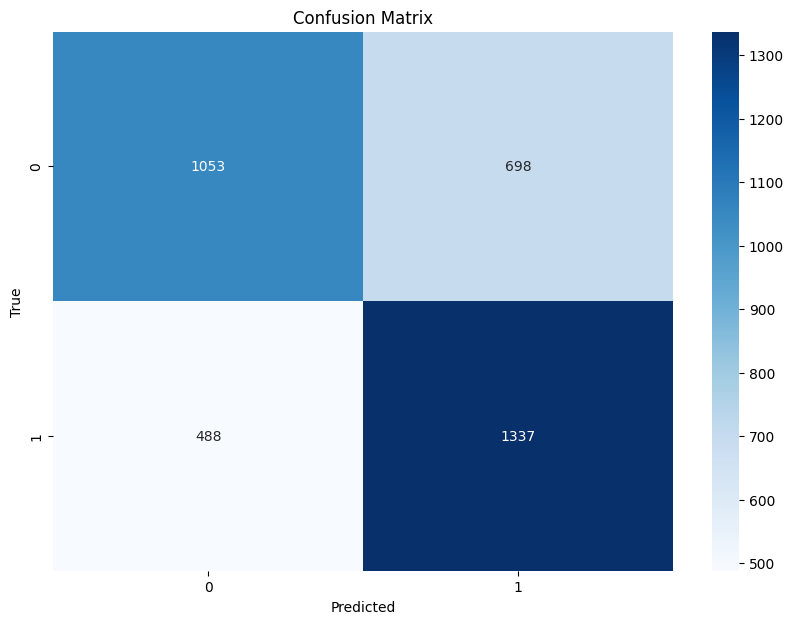

In [66]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_svc_pca)

# Plot the confusion matrix

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_recall_curve
import numpy as np

# Define the parameter grid to search over
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['linear', 'rbf']
}

# Initialize the SVC
svc = SVC(probability=True)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='accuracy', cv=3, verbose=1, n_jobs=1)

# Fit the grid search to the data
grid_search.fit(X_train_combined_pca, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_




Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [57]:
!pip install matplotlib

In [60]:
!pip install sklearn

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [62]:
!pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 23.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


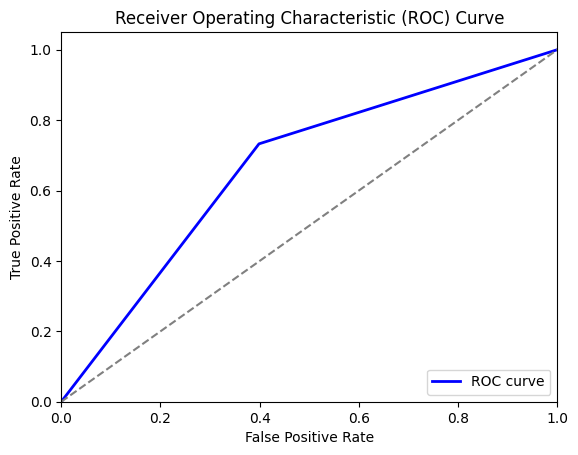

In [72]:
from sklearn.metrics import roc_curve

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_svc_pca)

# Plot ROC curve
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [23]:
#loading the data
# Load data from a text file
def load_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            label, sentence = line.strip().split('\t', 1)  # Split on the first tab character
            data.append([sentence, int(label)])
    return pd.DataFrame(data, columns=['text', 'tag'])

# file_path
file_path = 'REAL_DATA.txt'

#assign the data into pandas DF
real = load_data(file_path)

real.head()

,text,tag
0,Yo no creo que a nadie le haya encantado un pe...,2
1,No va a resolver sus problemas de crédito o me...,2
2,Te encantará este !,2
3,Yo estaba a volar a un aeropuerto varias horas...,2
4,"( Maid En Manhattan , The Wedding Planner , Je...",2


In [ ]:
#### fit the model with all the training dataset

In [46]:
# Concatenate along rows
X_pca = np.concatenate((X_train_combined_pca, X_test_combined_pca), axis=0)
yt = np.concatenate((y_train, y_test), axis=0)

In [43]:
X_test_combined_pca.shape
X_test_combined_pca.shape

(3576, 407)

In [44]:
y_test.shape
y_train.shape

(14301,)

In [47]:
yt.shape

(17877,)

In [50]:
X_pca.shape

(17877, 407)

In [51]:
svm_classifier2.fit(X_pca, yt)

SVC(kernel='linear')

In [25]:
# Apply embedding to the 'sentences' column
real['embedding'] = real['text'].apply(embed_text)
  # Apply preprocessing
real['clean_text'] = real['text'].apply(preprocess_text)

# Perform POS tagging
real['pos_tags'] = real['clean_text'].apply(lambda x: ' '.join([pos for word, pos in nltk.pos_tag(nltk.word_tokenize(x))]))
# Add punctuation frequency features to the DataFrame
real['punctuation_freq'] = real['text'].apply(punctuation_frequency)

In [52]:
real.head()

,text,tag,embedding,clean_text,pos_tags,punctuation_freq
0,Yo no creo que a nadie le haya encantado un pe...,2,"[0.7163733, -0.052741367, 0.02028712, 0.339568...",yo no creo que a nadie le haya encantado un pe...,NN DT NN VBZ DT JJ NN NN NN JJ NN NN NN,"{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ..."
1,No va a resolver sus problemas de crédito o me...,2,"[-0.7139319, 0.13840851, 0.46272853, 0.0509615...",no va a resolver sus problemas de cr dito o me...,DT NN DT NN NN NN IN NN NN NN NN NN NN JJ NN N...,"{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ..."
2,Te encantará este !,2,"[0.37122592, -0.19369999, 1.2330148, -0.320148...",te encantar este,NN NN NN,"{'!': 1, '""': 0, '#': 0, '$': 0, '%': 0, '&': ..."
3,Yo estaba a volar a un aeropuerto varias horas...,2,"[-0.066193506, -0.80570453, -0.3356248, -1.475...",yo estaba a volar a un aeropuerto varias horas...,NN VBZ DT NN DT JJ NN NN FW FW FW JJ JJ NN VBD...,"{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ..."
4,"( Maid En Manhattan , The Wedding Planner , Je...",2,"[0.40220252, -0.52340543, 0.76206815, -0.63828...",maid en manhattan the wedding planner jersey g...,NN NN VBD DT NN NN NN NN NN IN NN NN DT NN RP ...,"{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ..."


In [53]:
# 3. Transform features
# POS Vectorizer
pos_vec = pos_vectorizer.transform(real['pos_tags']).toarray()

# Punctuation Frequency Vectorizer
punctuation = vectorizer.transform(real['punctuation_freq'])

# Flatten or reshape BERT embeddings
new_embedding_flat = np.vstack(real['embedding']).reshape(len(real), -1)

# Combine flattened BERT embeddings with other features
combined = np.hstack((new_embedding_flat, pos_vec, punctuation))

# Apply PCA
new_combined_pca = pca.transform(combined)

# 4. Make predictions
y_pred_new = svm_classifier2.predict(new_combined_pca)

# 5. Update the 'tag' column in the new dataset with the predicted labels
real['pred'] = y_pred_new



In [54]:
real.head()

,text,tag,embedding,clean_text,pos_tags,punctuation_freq,pred
0,Yo no creo que a nadie le haya encantado un pe...,2,"[0.7163733, -0.052741367, 0.02028712, 0.339568...",yo no creo que a nadie le haya encantado un pe...,NN DT NN VBZ DT JJ NN NN NN JJ NN NN NN,"{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ...",1
1,No va a resolver sus problemas de crédito o me...,2,"[-0.7139319, 0.13840851, 0.46272853, 0.0509615...",no va a resolver sus problemas de cr dito o me...,DT NN DT NN NN NN IN NN NN NN NN NN NN JJ NN N...,"{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ...",0
2,Te encantará este !,2,"[0.37122592, -0.19369999, 1.2330148, -0.320148...",te encantar este,NN NN NN,"{'!': 1, '""': 0, '#': 0, '$': 0, '%': 0, '&': ...",0
3,Yo estaba a volar a un aeropuerto varias horas...,2,"[-0.066193506, -0.80570453, -0.3356248, -1.475...",yo estaba a volar a un aeropuerto varias horas...,NN VBZ DT NN DT JJ NN NN FW FW FW JJ JJ NN VBD...,"{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ...",0
4,"( Maid En Manhattan , The Wedding Planner , Je...",2,"[0.40220252, -0.52340543, 0.76206815, -0.63828...",maid en manhattan the wedding planner jersey g...,NN NN VBD DT NN NN NN NN NN IN NN NN DT NN RP ...,"{'!': 0, '""': 0, '#': 0, '$': 0, '%': 0, '&': ...",1


In [73]:
real[['pred', 'text']].to_csv('final_predictions.txt', sep='\t', header=False, index=False)